In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, basinhopping

In [23]:
# Physical constraints
E = 100  # Relative tensile modululs
t = 1.2  # Spring thickness

n = 10  # Number of spring elements to compute
keep_out_penalty = 1e9

neutral_roller_center = np.array([17.58, -7.2])
deflected_roller_center = np.array([18.62, 3.78])
shaft_center = np.array([0, 0])

roller_radius = 8
shaft_radius = 5.5

rolling_end_neutral_angle = 13.58 * np.pi / 180
rolling_end_deflected_angle = 89 * np.pi / 180

fixed_end_domain_length = 6
rolling_end_domain_length = 8.1

In [24]:
def keep_out_check(r, origin, radius, endpoints=False):
    if endpoints:
        return np.sum((r - origin)**2, axis=1) < radius*radius
    else:
        return np.sum((r[1:-1] - origin)**2, axis=1) < radius*radius


end_point_ds = 0.1
def fixed_end(x):
    return np.array([[-2 + fixed_end_domain_length*x - end_point_ds, -9.56],
                     [-2 + fixed_end_domain_length*x, -9.56]])

def rolling_end_neutral(x):
    return np.array([[13.7 + (x*rolling_end_domain_length)*np.cos(rolling_end_neutral_angle), 
                      1 + (x*rolling_end_domain_length)*np.sin(rolling_end_neutral_angle)],
                     [13.7 + (x*rolling_end_domain_length + end_point_ds)*np.cos(rolling_end_neutral_angle), 
                      1 + (x*rolling_end_domain_length + end_point_ds)*np.sin(rolling_end_neutral_angle)]])

def rolling_end_deflected(x):
    return np.array([[9.7 + x*rolling_end_domain_length*np.cos(rolling_end_deflected_angle),  
                      2.1 + x*rolling_end_domain_length*np.sin(rolling_end_deflected_angle)],
                     [9.7 + (x*rolling_end_domain_length + end_point_ds)*np.cos(rolling_end_deflected_angle),  
                      2.1 + (x*rolling_end_domain_length + end_point_ds)*np.sin(rolling_end_deflected_angle)]])

In [25]:
#  Neutral spring postion initial guess
guess_r0 = np.zeros([n, 2])
guess_r0[:, 0] = np.linspace(1, 13.7, num=n+1, endpoint=False)[1:]
guess_r0[:, 1] = (guess_r0[:, 0] - 13.7) * (10.56 / 12.7) + 1 + np.sin(guess_r0[:, 0]*30)*0.5
#  Deflected spring position initial guess
guess_r1 = np.zeros_like(guess_r0)
guess_r1[:, 0] = np.linspace(1, 9.7, num=n+1, endpoint=False)[1:]
guess_r1[:, 1] = (guess_r1[:, 0] - 9.7) * (11.66 / 8.7) + 2.1 #+ np.sin(guess_r1[:, 0]*30)

#  Initital Guess
x0 = np.zeros(4*n+2)
x0[-1] = 0.5
x0[-2] = 0
x0[:n] = guess_r0[:, 0]
x0[n:2*n] = guess_r0[:, 1]
x0[2*n:3*n] = guess_r1[:, 0]
x0[3*n:4*n] = guess_r1[:, 1]

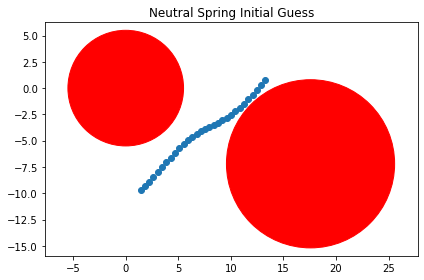

In [26]:
#  Plot the initial guess and keep out zones
shaft_circle = plt.Circle(shaft_center, shaft_radius, color='r')
neutral_roller_circle = plt.Circle(neutral_roller_center, roller_radius, color='r')


plt.close()
fig, ax = plt.subplots()
plt.scatter(guess_r0[:, 0], guess_r0[:, 1])
ax.add_patch(shaft_circle)
ax.add_patch(neutral_roller_circle)

X = np.linspace(0, 1)
"""
plt.scatter(list(map(lambda x: fixed_end(x)[0, 0], X)), 
            list(map(lambda x: fixed_end(x)[0, 1], X)))
plt.scatter(list(map(lambda x: rolling_end_neutral(x)[0, 0], X)), 
            list(map(lambda x: rolling_end_neutral(x)[0, 1], X)))
"""
plt.title("Neutral Spring Initial Guess")
plt.axis('equal')
plt.tight_layout()

plt.show()

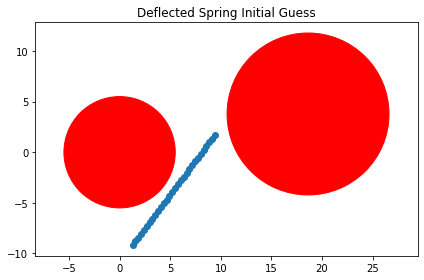

In [27]:
shaft_circle = plt.Circle(shaft_center, shaft_radius, color='r')
deflected_roller_circle = plt.Circle(deflected_roller_center, roller_radius, color='r')

plt.close()
fig, ax = plt.subplots()
plt.scatter(guess_r1[:, 0], guess_r1[:, 1])
ax.add_patch(shaft_circle)
ax.add_patch(deflected_roller_circle)

"""X = np.linspace(0, 1)
plt.scatter(list(map(lambda x: fixed_end(x)[0, 0], X)), 
            list(map(lambda x: fixed_end(x)[0, 1], X)))
plt.scatter(list(map(lambda x: rolling_end_deflected(x)[0, 0], X)), 
            list(map(lambda x: rolling_end_deflected(x)[0, 1], X)))
"""
plt.title("Deflected Spring Initial Guess")
plt.axis('equal')
plt.tight_layout()

plt.show()

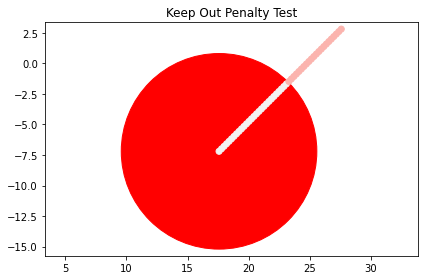

[17.58 -7.2 ] [27.58  2.8 ]


In [28]:
keep_out_test = np.zeros([50, 2])
keep_out_test[:, 0] = np.linspace(0, 10) + neutral_roller_center[0]
keep_out_test[:, 1] = np.linspace(0, 10) + neutral_roller_center[1]

plt.close()
neutral_roller_circle = plt.Circle(neutral_roller_center, roller_radius, color='r')
fig, ax = plt.subplots()
ax.add_patch(neutral_roller_circle)
plt.scatter(keep_out_test[:, 0], keep_out_test[:, 1], 
            c=keep_out_check(keep_out_test, neutral_roller_center, roller_radius, endpoints=True), cmap='Pastel1')
plt.title('Keep Out Penalty Test')
plt.axis('equal')
plt.tight_layout()
plt.show()

print(keep_out_test[0], keep_out_test[-1])

In [29]:
# Discretized vector calc functions

def velocity(r):
    # The curve's velocity as a function of the indexing
    return (r[2:] - r[:-2])/2

def acceleration(r):
    # The curve's acceleration as a function of the indexing
    return r[:-2] - 2*r[1:-1] + r[2:]

def cross(v, a):
    # The z component of the cross product that is proportional to the signed curvature
    return (v[:, 0] * a[:, 1]) - (v[:, 1] * a[:, 0])

def arc_length(r):
    return (np.sqrt(np.sum((r[:-2] - r[1:-1])**2, axis=1)) + np.sqrt(np.sum((r[1:-1] - r[2:])**2, axis=1)))/2
    
def curvature(r):
    # r is the position of the spring elements
    s = arc_length(r)
    return cross(velocity(r), acceleration(r)) / s**3

In [ ]:
# Testing the vector calc functions
i = np.linspace(0, np.pi*2, num=300)
circle_path = np.zeros([i.shape[0], 2])
circle_path[:, 0] = 3*np.cos(i)
circle_path[:, 1] = 3*np.sin(i)

vel_test = velocity(circle_path)
acc_test = acceleration(circle_path)
arc_test = arc_length(circle_path)
crv_test = curvature(circle_path)

In [ ]:
plt.close()
fig, ax = plt.subplots()
plt.quiver(circle_path[1:-1:10, 0], circle_path[1:-1:10, 1], vel_test[::10, 0], vel_test[::10, 1])
plt.axis('equal')
plt.title('Velocity Test')
plt.tight_layout()
plt.show()

In [ ]:
plt.close()
fig, ax = plt.subplots()
plt.quiver(circle_path[1:-1:10, 0], circle_path[1:-1:10, 1], acc_test[::10, 0], acc_test[::10, 1])
plt.axis('equal')
plt.title('Acceleration Test')
plt.tight_layout()
plt.show()

In [ ]:
print(np.allclose(arc_test, arc_test[0]))
print('Computed circumference: {:.3f}, Analytical circumference: {:.3f}'.format(np.sum(arc_test) + arc_test[0], 
                                                                               2*np.pi*3))

In [ ]:
# Curvature should be the reciprocal of the radius
print(np.allclose(crv_test, crv_test[0]))
print(1/crv_test[0])
print(1/curvature(circle_path[::-1])[0])

In [30]:
def neutral_axis_displacement(k):
    # Returns the maximum distance from the neutral axis for a curved section with curvature k
    return (np.exp(-k*t)*(1+k*t)-1) / (np.exp(-k*t)-1)

def flexural_strain(k0, k1, y):
    # Increasing y represents fibers towards the center of curvature
    return (k0 - k1) * y / (1 - np.abs(k0)*y)

def tensile_strain(s0, s1):
    return (s1 - s0) / s0

In [31]:
def stress(r0, r1):
    s0 = arc_length(r0)
    s1 = arc_length(r1)
    k0 = curvature(r0)
    k1 = curvature(r1)
    
    return (np.abs(flexural_strain(k0, k1, neutral_axis_displacement(k1))) +
            E * np.abs(tensile_strain(s0, s1)) +
            keep_out_penalty * (keep_out_check(r0, shaft_center, shaft_radius) +
                                keep_out_check(r1, shaft_center, shaft_radius) +
                                keep_out_check(r0, neutral_roller_center, roller_radius) +
                                keep_out_check(r1, deflected_roller_center, roller_radius)))

def stress_objective_func(x):
    # x is the optimization parameters
    # x[-1] is the fixed end position scalar
    # x[-2] it the rolling end position scalar
    # the next n elements are the x-components of the neutral spring
    # the next n elements are the y-components of the netural spring
    # the next n elements are the x-components of the deflected spring
    # the next n elements are the y-components of the deflected spring    
    r0 = np.zeros([n+4, 2])
    r0[0:2] = fixed_end(x[-1])
    r0[-2:] = rolling_end_neutral(x[-2])
    r0[2:-2, 0] = x[:n]
    r0[2:-2, 1] = x[n:2*n]
    
    r1 = np.copy(r0)
    r1[-2:] = rolling_end_deflected(x[-2])
    r1[2:-2, 0] = x[2*n:3*n]
    r1[2:-2, 1] = x[3*n:4*n]
    
    return np.max(stress(r0, r1))

In [32]:
# Warning, running this cell will eat all your cpu resources for a bit

bounds = Bounds(([-2]*n + [-10]*n)*2 + [0]*2,
                ([15]*n + [3]*n)*2 + [1]*2)

minimizer_kwargs = {"method": 'trust-constr', "bounds": bounds}

solution = basinhopping(stress_objective_func, x0, minimizer_kwargs=minimizer_kwargs)
#solution = minimize(stress_objective_func, x0, method='trust-constr', bounds=limits)

/usr/lib/python3/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


KeyboardInterrupt: 

In [ ]:
# TODO plot the results of the optimization
# TODO export the solution into an onshape friendly format, maybe a dxf file
solution.x

In [ ]:
# Plot the solution

sol_neutral = np.zeros([n+4, 2])
sol_neutral[:2] = fixed_end(solution.x[-1])
sol_neutral[-2:] = rolling_end_neutral(solution.x[-2])
sol_neutral[2:-2, 0] = solution.x[:n]
sol_neutral[2:-2, 1] = solution.x[n:2*n]

plt.close()
fig, ax = plt.subplots()
plt.scatter(sol_neutral[:, 0], sol_neutral[:, 1])
plt.tight_layout()
plt.show()

In [ ]:
sol_deflected = np.zeros([n+4, 2])
sol_deflected[:2] = fixed_end(solution.x[-1])
sol_deflected[-2:] = rolling_end_deflected(solution.x[-2])
sol_deflected[2:-2, 0] = solution.x[2*n:3*n]
sol_deflected[2:-2, 1] = solution.x[3*n:4*n]

plt.close()
fig, ax = plt.subplots()
plt.scatter(sol_deflected[1:-1, 0], sol_deflected[1:-1, 1], c=stress(sol_neutral, sol_deflected))
plt.tight_layout()
plt.show()

In [ ]:
stress(sol_neutral, sol_deflected)

In [ ]:
flexural_strain(curvature(sol_neutral), curvature(sol_deflected), neutral_axis_displacement(curvature(sol_neutral)))

In [ ]:
tensile_strain(arc_length(sol_neutral), arc_length(sol_deflected))